In [1]:
import sys
sys.path.append('..')

import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.layers import *
import pandas as pd
import numpy as np
from position import Position
import matplotlib.pyplot as plt
%matplotlib inline
import imp
# imp.reload(cnnfeat)
from multiprocessing import Queue
from multiprocessing import Manager, Process, Pool
import os
from time import time
import pickle
import bcolz
from tqdm import tqdm 
from cnnfeat import get_feats
import numpy as np

Using TensorFlow backend.


Initializing Magics


In [2]:
from tools.cycliclr import CyclicLR
from math import ceil

In [155]:
def dense_model():
    net_input = Input((8,8,14))
    x = Dense(64)(net_input)
    x = Activation('relu')(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(8*8*11*8, kernel_regularizer=regularizers.l2(0.001))(x)
    output = Activation('softmax')(x)
#     x = Dense(1)(x)
#     output = Activation('tanh')(x)
    return net_input, output

In [140]:
inputs, output = dense_model()
model = Model(inputs, output)

In [141]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8, 8, 14)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 8, 8, 64)          960       
_________________________________________________________________
activation_4 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
dense_5 (Dense)              (None, 8, 8, 32)          2080      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5632)              11539968  
__________

In [142]:
def label_to_san(label):
    coords = np.unravel_index(label, (8,8,11,8))
    from_sq, to_sq = coords[0:2], coords[2:4]
    return coord_to_san(from_sq) + coord_to_san(to_sq)
    
def coord_to_san(coord):
    y, x = coord
    promo = ''
    if y >= 7:
        pt = y - 7
        y = 7
        if pt == 0: promo = ''
        elif pt == 1: promo = 'n'
        elif pt == 2: promo = 'b'
        elif pt == 3: promo = 'r'
    return chr(x+97) + str(y+1) + promo

label_to_san(san_to_label('e3g4'))

'e3g4'

In [143]:
def san_to_label(san_move):
    """ Return index into 8*8*11*8 possibilities of from_sq (row*col) to to_sq (row*col).
    3 rows are added for underpromotions. """
    # g5 => row 5, col 7(g) => (4, 6)
    # h6 => row 6, col 8(h) => (5, 7) 
    from_coord = [int(san_move[1:2]) - 1, ord(san_move[0:1]) - 97]
    to_coord = [int(san_move[3:4]) - 1, ord(san_move[2:3]) - 97]
    if len(san_move) == 5:
        if san_move[4:5] == 'n': to_coord[0] += 1
        elif san_move[4:5] == 'b': to_coord[0] += 2
        elif san_move[4:5] == 'r': to_coord[0] += 3
    return np.ravel_multi_index(from_coord + to_coord, (8,8,11,8), order='C')

def sans_to_labels(san_moves):
    return list(map(san_to_label, san_moves))

In [144]:
def batch_generator_df_bcolz(dframe, bcolz_arr, batch_size, shuffle=True, yielder=lambda x: x):
    assert(batch_size % bcolz_arr.chunklen == 0)
    chunks_per_batch = batch_size // bcolz_arr.chunklen
    init_bounds = bcolz_arr.partitions
    if bcolz_arr.leftover_elements > 0:
        init_bounds.append((init_bounds[-1][1], len(bcolz_arr)))
    while True:
        bounds = np.random.permutation(init_bounds) if shuffle else init_bounds
        # feats_chunks, scores_chunks = [], []
        feats_chunks, move_chunks = [], []
        def return_batch():
            feats = np.concatenate(feats_chunks, axis=0)
            moves = np.concatenate(move_chunks, axis=0)
            feats_chunks.clear()
            move_chunks.clear()
            return yielder((feats, moves))
        chunks = 0
        for start, stop in bounds:
            feats_chunks.append(bcolz_arr[start:stop])
            moves = np.array(dframe[start:stop].move)
            move_chunks.append(sans_to_labels(moves))
            chunks += 1
            if chunks % chunks_per_batch == 0:
                yield return_batch()
        if len(feats_chunks) > 0:
            yield return_batch()

In [7]:
from bcolz_array_iterator import BcolzArrayIterator

def batch_generator_bcolz(data, batch_size, shuffle=True):
    batch_generator_bcolz = BcolzArrayIterator(data, batch_size=batch_size, shuffle=shuffle)
    while True:
        feats = next(batch_generator_bcolz)
        yield feats, feats

In [8]:
def batch_generator_df(data, batch_size, shuffle=True):
    while True:
        data_ = data.sample(frac=1) if shuffle else data
        for iteration, batch in data_.groupby(np.arange(len(data)) // batch_size):
            fens = [f.strip() for f in batch.fen.tolist()]
            feats = np.stack([get_feats(Position.from_fen(fen)) for fen in fens])
            yield feats, feats

In [150]:
# model.compile(keras.optimizers.SGD(lr=.01, momentum=.99, nesterov=True), 'mse')

In [145]:
model.compile('adam', 'sparse_categorical_crossentropy')

In [9]:
features = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_move_scores_sf4_origfen.bc')
features_valid = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_move_scores_sf4_origfen_valid.bc')

In [10]:
move_scores = pd.read_pickle('/ssd/slonik_data/sf_move_scores_4dep.pkl')

In [11]:
def get_feats_stack(fens):
    return np.stack([get_feats(Position.from_fen(f)) for f in fens])

In [12]:
assert(np.allclose(features_valid[0], get_feats(Position.from_fen(move_scores.iloc[-60000].orig_fen))))
assert(np.allclose(features_valid[0:100], get_feats_stack(move_scores.iloc[-60000:-60000+100].orig_fen)))
assert(np.allclose(features[0], get_feats(Position.from_fen(move_scores.iloc[0].orig_fen))))
assert(np.allclose(features[23470:23570], get_feats_stack(move_scores.iloc[23470:23570].orig_fen)))

In [146]:
wgts = model.get_weights()

In [44]:
model.set_weights(wgts)

In [135]:
%pwd

'/home/maks/projects/slonik/notebooks'

In [181]:
batch_size = 64
#nvalid = len(features_sf12_valid)

x = features
x_valid = features_valid

# yielder = lambda f_s: (f_s[0], [f_s[0], f_s[1]]) # (feats, [feats, scores])
train_gen = batch_generator_df_bcolz(move_scores, x, batch_size)
valid_gen = batch_generator_df_bcolz(move_scores[-60000:], x_valid, batch_size, shuffle=False)

train_steps = ceil(len(x) / batch_size)
valid_steps = ceil(len(x_valid) / batch_size)

# lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1)
# checkpoint_path = '../slonik_data/weights.{epoch:03d}-{val_loss:.6f}.h5'
checkpoint_path = '../../slonik_data/weights_best.h5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                             monitor='val_loss', save_best_only=True, save_weights_only=True, period=1)
# stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto')
# clr = CyclicLR(base_lr=1e-4, max_lr=1.25e-3, step_size=train_steps*4, mode='triangular')

# callbacks = [clr]
# callbacks = [clr, checkpoint]
# K.set_value(train_model.optimizer.lr, 1e-3)
model.fit_generator(train_gen, train_steps, epochs=16, 
                          validation_data=valid_gen, validation_steps=valid_steps
                          #, callbacks=callbacks
                   )

K.set_value(model.optimizer.lr, 1e-4)
# model.fit_generator(train_gen, train_steps, epochs=2, validation_data=valid_gen, validation_steps=valid_steps)

Epoch 1/16
9851/9851 [==============================] - 146s 15ms/step - loss: 2.9451 - val_loss: 3.0631
Epoch 2/16
9851/9851 [==============================] - 146s 15ms/step - loss: 2.9386 - val_loss: 3.0532
Epoch 3/16
9851/9851 [==============================] - 146s 15ms/step - loss: 2.9383 - val_loss: 3.0615
Epoch 4/16
 465/9851 [>.............................] - ETA: 2:16 - loss: 2.7125

KeyboardInterrupt: 

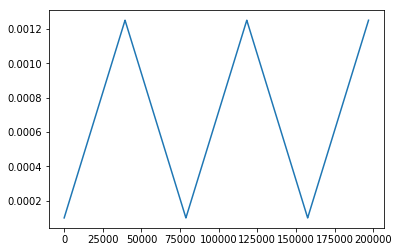

In [46]:
plt.plot(clr.history['iterations'], clr.history['lr'])

In [22]:
clr.history.keys()

dict_keys(['lr', 'iterations', 'batch', 'size', 'loss'])

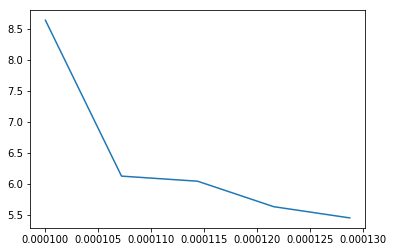

In [47]:
rng = np.s_[:1000:train_steps//40]
plt.plot(clr.history['lr'][rng], clr.history['loss'][rng])

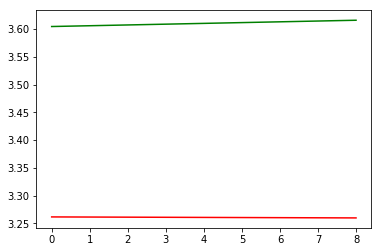

In [182]:
hist = Out[163].history
rng = np.s_[::8]
x = np.arange(len(hist['loss']))
plt.plot(x[rng], hist['loss'][rng], 'r', x[rng], hist['val_loss'][rng], 'g')

### evaluate models

In [160]:
batch_size = 64
valid_steps = ceil(len(features_valid) / batch_size)
valid_gen = batch_generator_df_bcolz(move_scores[-60000:], features_valid, batch_size, shuffle=False)
model.evaluate_generator(valid_gen, steps=valid_steps)
# train_model.metrics_names
# K.get_value(train_model.optimizer.lr)
# 0.0010100496762121718 adam clr

3.0940114992777508

In [195]:
model.save_weights('../../slonik_data/weights_best_mlp0_policy_3.06.h5')

In [158]:
model.load_weights('../../slonik_data/weights_best_3.0940.h5')

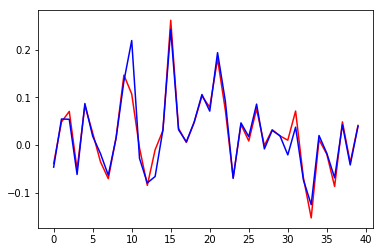

In [177]:
rng = slice(100,140)
dfrng = slice(rng.start+-60000, rng.stop+-60000)
fens = move_scores[dfrng].fen
scores = move_scores[dfrng].score
# np.allclose(features_sf12_valid[rng], np.array([get_feats(Position.from_fen(f)) for f in fens]))
# pprint(list(zip(scores, evaluator.predict(features_sf12_valid[rng]).squeeze())))
x = np.arange(len(scores))
plt.plot(x, scores, 'r')
plt.plot(x, model.predict(features_sf3_valid_sample[rng]).squeeze(), 'b')

In [19]:
model.predict(features_sf3_valid_sample[rng]).shape

(40, 8, 8, 1)

In [194]:
n = 207
print(Position.from_fen(move_scores.iloc[-60000+n].orig_fen))
print(move_scores.iloc[-60000+n].move)
preds = model.predict(features_valid[n][None])[0]
label_to_san(np.argmax(preds))
topk = np.argpartition(preds, -5)[-5:]
topk_sorted = topk[np.argsort(preds[topk])][::-1]
topk_sorted
[label_to_san(k) for k in topk_sorted]

W to move
 ♜  ·  ·  ♛  ·  ♜  ♚  · 
 ♟  ♝  ·  ·  ·  ♟  ♟  ♟ 
 ·  ♟  ♟  ·  ♟  ♞  ·  · 
 ·  ·  ·  ·  ♝  ·  ·  · 
 ·  ·  ♙  ♟  ·  ♙  ♙  · 
 ·  ♙  ♘  ·  ♙  ·  ·  · 
 ♙  ♗  ♕  ♙  ♗  ·  ·  ♙ 
 ♖  ·  ·  ·  ♔  ·  ♖  · 

f4e5


['f4e5', 'g4g5', 'd2d3', 'b2a3', 'd2d4']